In [2]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_score, recall_score, f1_score, accuracy_score)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('processeddataset/final_feature_paySim.csv')
df.head()

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0   9839.64       170136.0       160296.36             0.0             0.0   
1   1864.28        21249.0        19384.72             0.0             0.0   
2    181.00          181.0            0.00             0.0             0.0   
3    181.00          181.0            0.00         21182.0             0.0   
4  11668.14        41554.0        29885.86             0.0             0.0   

   hour  is_weekend  high_risk_hour  high_risk_type  large_amount_flag  \
0     1           0               1               0                  0   
1     1           0               1               0                  0   
2     1           0               1               1                  0   
3     1           0               1               1                  0   
4     1           0               1               0                  0   

   zero_balance_orig  zero_balance_dest  balance_ratio_orig  \
0                  0                  1            0.057834   
1                  0                  1            0.087731   
2                  0                  1            0.994505   
3                  0                  0            0.994505   
4                  0                  1            0.280788   

   balance_ratio_dest  cust_avg_amt  cust_std_amt  cust_txn_count  isFraud  
0         9839.640000       9839.64           0.0               1        0  
1         1864.280000       1864.28           0.0               1        0  
2          181.000000        181.00           0.0               1        1  
3            0.008545        181.00           0.0               1        1  
4        11668.140000      11668.14           0.0               1        0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   amount              float64
 1   oldbalanceOrg       float64
 2   newbalanceOrig      float64
 3   oldbalanceDest      float64
 4   newbalanceDest      float64
 5   hour                int64  
 6   is_weekend          int64  
 7   high_risk_hour      int64  
 8   high_risk_type      int64  
 9   large_amount_flag   int64  
 10  zero_balance_orig   int64  
 11  zero_balance_dest   int64  
 12  balance_ratio_orig  float64
 13  balance_ratio_dest  float64
 14  cust_avg_amt        float64
 15  cust_std_amt        float64
 16  cust_txn_count      int64  
 17  isFraud             int64  
dtypes: float64(9), int64(9)
memory usage: 873.8 MB


In [5]:
df.shape

(6362620, 18)

In [6]:
df.isna().sum()

amount                0
oldbalanceOrg         0
newbalanceOrig        0
oldbalanceDest        0
newbalanceDest        0
hour                  0
is_weekend            0
high_risk_hour        0
high_risk_type        0
large_amount_flag     0
zero_balance_orig     0
zero_balance_dest     0
balance_ratio_orig    0
balance_ratio_dest    0
cust_avg_amt          0
cust_std_amt          0
cust_txn_count        0
isFraud               0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(4900)

In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [12]:
fraud = df[df['isFraud']==1]
non_fraud = df[df['isFraud']==0].sample(n=fraud.shape[0], random_state=42)

In [13]:
new_df = pd.concat([fraud, non_fraud]).reset_index(drop=True)
new_df.head()

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0    181.0          181.0             0.0             0.0             0.0   
1    181.0          181.0             0.0         21182.0             0.0   
2   2806.0         2806.0             0.0             0.0             0.0   
3   2806.0         2806.0             0.0         26202.0             0.0   
4  20128.0        20128.0             0.0             0.0             0.0   

   hour  is_weekend  high_risk_hour  high_risk_type  large_amount_flag  \
0     1           0               1               1                  0   
1     1           0               1               1                  0   
2     1           0               1               1                  0   
3     1           0               1               1                  0   
4     1           0               1               1                  0   

   zero_balance_orig  zero_balance_dest  balance_ratio_orig  \
0                  0                  1            0.994505   
1                  0                  0            0.994505   
2                  0                  1            0.999644   
3                  0                  0            0.999644   
4                  0                  1            0.999950   

   balance_ratio_dest  cust_avg_amt  cust_std_amt  cust_txn_count  isFraud  
0          181.000000         181.0           0.0               1        1  
1            0.008545         181.0           0.0               1        1  
2         2806.000000        2806.0           0.0               1        1  
3            0.107087        2806.0           0.0               1        1  
4        20128.000000       20128.0           0.0               1        1

In [14]:
new_df.shape

(16426, 18)

In [21]:
feature_columns = [
'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
'hour', 'is_weekend', 'high_risk_hour', 'high_risk_type', 'large_amount_flag',
'zero_balance_orig', 'zero_balance_dest', 'balance_ratio_orig', 'balance_ratio_dest',
'cust_avg_amt', 'cust_std_amt', 'cust_txn_count'
]
X = df[feature_columns]
y = df['isFraud']

In [22]:
print("Original class distribution:", Counter(y))
print(f"Fraud rate: {y.mean():.6f}")

Original class distribution: Counter({0: 6354407, 1: 8213})
Fraud rate: 0.001291


In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

In [24]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4453834, 17), (1908786, 17), (4453834,), (1908786,))

* On Apply ROS

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train) # type: ignore
y_train_ros.value_counts()

isFraud
0    4448085
1    4448085
Name: count, dtype: int64

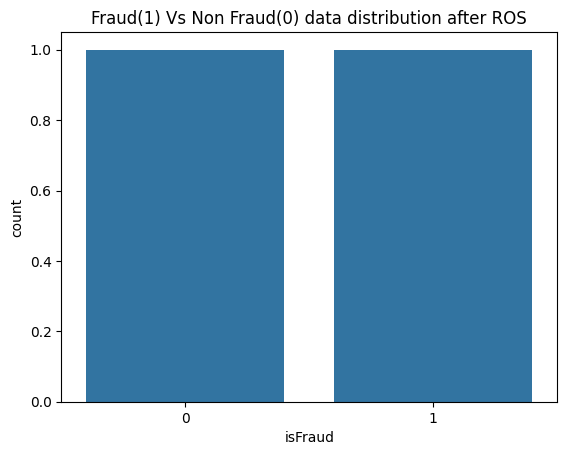

In [14]:
sns.countplot(y_train_ros.value_counts())  # type: ignore
plt.title("Fraud(1) Vs Non Fraud(0) data distribution after ROS")
plt.show()


In [8]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [12]:
mlflow.set_experiment("Anomaly_Detection_Models_ROS")

2025/10/20 19:32:28 INFO mlflow.tracking.fluent: Experiment with name 'Anomaly_Detection_Models_ROS' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/410605394061670739', creation_time=1760968948250, experiment_id='410605394061670739', last_update_time=1760968948250, lifecycle_stage='active', name='Anomaly_Detection_Models_ROS', tags={}>

In [9]:
def calculate_metrics(y_true, y_pred, y_scores, model_name):

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Business metrics
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    true_positive_rate = recall  # Same as recall
    
    # Classification report
    cr = classification_report(y_true, y_pred, output_dict=True)
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'true_positive_rate': true_positive_rate,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'classification_report': cr,
        'predictions': y_pred,
        'scores': y_scores
    }
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    
    return results


In [10]:
def log_model_to_mlflow(model, metrics, model_name, params):

    # Log parameters
    for param, value in params.items():
        mlflow.log_param(param, value)
    
    # Log metrics
    mlflow.log_metric("accuracy", metrics['accuracy'])
    mlflow.log_metric("precision", metrics['precision'])
    mlflow.log_metric("recall", metrics['recall'])
    mlflow.log_metric("f1_score", metrics['f1_score'])
    mlflow.log_metric("roc_auc", metrics['roc_auc'])
    mlflow.log_metric("false_positive_rate", metrics['false_positive_rate'])
    mlflow.log_metric("false_negative_rate", metrics['false_negative_rate'])
    mlflow.log_metric("true_positive_rate", metrics['true_positive_rate'])
    mlflow.log_metric("true_positives", metrics['true_positives'])
    mlflow.log_metric("false_positives", metrics['false_positives'])
    mlflow.log_metric("true_negatives", metrics['true_negatives'])
    mlflow.log_metric("false_negatives", metrics['false_negatives'])
    
    # Log classification report as JSON
    mlflow.log_dict(metrics['classification_report'], "classification_report.json")
    
    # Log confusion matrix as plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"confusion_matrix_{model_name.replace(' ', '_')}.png")
    plt.close()
    
    # Log model
    mlflow.sklearn.log_model(model, name = f"model_{model_name.replace(' ', '_')}",
                             input_example=X_train.head(5))

In [ ]:
import joblib
import os
results = {}
with mlflow.start_run(run_name="Isolation_Forest"):
        # Train Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=100,
            contamination=0.01,  # Approximate fraud rate
            random_state=42,
            verbose=1
        )
        
        iso_forest.fit(X_train)
        
        # Predict on test set
        y_pred_iso = iso_forest.predict(X_test)
        y_scores_iso = iso_forest.decision_function(X_test)
        
        # Convert predictions (1 = normal, -1 = anomaly) to (0 = normal, 1 = anomaly)
        y_pred_iso_binary = (y_pred_iso == -1).astype(int)
        
        # Calculate metrics
        results['Isolation_Forest'] = calculate_metrics(
            y_test, y_pred_iso_binary, y_scores_iso, "Isolation Forest"
        )
        
        # Log to MLflow
        log_model_to_mlflow(
            iso_forest, 
            results['Isolation_Forest'], 
            "Isolation Forest",
            {
                'n_estimators': 100,
                'contamination': 0.01,
                'random_state': 42
            }
        )
        os.makedirs('models', exist_ok=True)
        joblib.dump(iso_forest, 'models/iso_forest_model.pkl')

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   27.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   59.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.2s finished



Isolation Forest Results:
Accuracy: 0.9897
Precision: 0.0399
Recall: 0.3040
F1-Score: 0.0705
ROC-AUC: 0.1812
False Positive Rate: 0.0095
False Negative Rate: 0.6960
Confusion Matrix:
[[1888283   18039]
 [   1715     749]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


🏃 View run Isolation_Forest at: http://127.0.0.1:5000/#/experiments/0/runs/91e7003869cc4053ae491aeb64f64aad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [ ]:
# from sklearn.model_selection import ParameterGrid


# mlflow.set_experiment("Isolation_Forest_Hyperparameter_Tuning")

# def hyperparameter_tuning(X_train, X_test, y_test):
#     # Define parameter grid
#     param_dist = {
#         'n_estimators': randint(50, 300),
#         'contamination': uniform(0.001, 0.1),  # 0.1% to 10%
#         'max_samples': uniform(0.5, 0.5),  # 0.5 to 1.0
#         'max_features': uniform(0.5, 0.5)   # 0.5 to 1.0
#     }
    
#     results = {}
#     best_score = -1
#     best_params = None
#     best_model = None
    
#     # Create all parameter combinations
#     grid = ParameterGrid(param_grid)
#     print(f"Total combinations to try: {len(grid)}")
    
#     for i, params in enumerate(grid):
#         with mlflow.start_run(run_name=f"IF_Tuning_{i}", nested=True):
#             # Log parameters
#             mlflow.log_params(params)
            
#             # Train Isolation Forest with current parameters
#             iso_forest = IsolationForest(
#                 n_estimators=params['n_estimators'],
#                 contamination=params['contamination'],
#                 max_samples=params['max_samples'],
#                 random_state=42,
#                 verbose=0
#             )
            
#             iso_forest.fit(X_train)
            
#             # Predict on test set
#             y_pred_iso = iso_forest.predict(X_test)
#             y_scores_iso = iso_forest.decision_function(X_test)
            
#             # Convert predictions (1 = normal, -1 = anomaly) to (0 = normal, 1 = anomaly)
#             y_pred_iso_binary = (y_pred_iso == -1).astype(int)
            
#             # Calculate metrics
#             current_results = calculate_metrics(y_test, y_pred_iso_binary, y_scores_iso, "Isolation Forest")
            
#             # Log metrics to MLflow
#             for metric_name, metric_value in current_results.items():
#                 if isinstance(metric_value, (int, float)):
#                     mlflow.log_metric(metric_name, metric_value)
            
#             # Track best model
#             f1_score = current_results.get('F1-Score', 0)
#             if f1_score > best_score:
#                 best_score = f1_score
#                 best_params = params
#                 best_model = iso_forest
            
#             # Log model
#             mlflow.sklearn.log_model(iso_forest, name = "ISOLATION_FOREST_model")
            
#             # Store results
#             results[f"run_{i}"] = {
#                 'params': params,
#                 'metrics': current_results
#             }
    
#     return best_model, best_params, best_score, results

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
mlflow.set_experiment("Isolation_Forest_Hyperparameter_Tuning_USing_RandomizedSearchCV")
def randomized_search_tuning(X_train, X_test, y_test, n_iter=5):
    # Define parameter distribution
    param_dist = {
        'n_estimators': randint(50, 300),
        'contamination': uniform(0.001, 0.1),  # 0.1% to 10%
        'max_samples': uniform(0.5, 0.5),  # 0.5 to 1.0
        'max_features': uniform(0.5, 0.5)   # 0.5 to 1.0
    }
    
    # Create Isolation Forest model
    iso_forest = IsolationForest(random_state=42, verbose=0)
    
    # Custom scorer for anomaly detection
    from sklearn.metrics import make_scorer, f1_score
    scorer = make_scorer(f1_score)
    
    with mlflow.start_run(run_name="RandomizedSearch_IF"):
        # Perform randomized search
        random_search = RandomizedSearchCV(
            estimator=iso_forest,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring=scorer,
            cv=3,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        
        # Fit the model
        random_search.fit(X_train)
        
        # Log best parameters
        mlflow.log_params(random_search.best_params_)
        
        # Get best model
        best_model = random_search.best_estimator_
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test) # type: ignore
        y_scores = best_model.decision_function(X_test) # type: ignore
        y_pred_binary = (y_pred == -1).astype(int)
        
        # Calculate and log metrics
        test_results = calculate_metrics(y_test, y_pred_binary, y_scores, "Best Isolation Forest")
        for metric_name, metric_value in test_results.items():
            if isinstance(metric_value, (int, float)):
                mlflow.log_metric(f"test_{metric_name}", metric_value)
        
        # Log the best model
        mlflow.sklearn.log_model(best_model, "best_model") # type: ignore
        
        # Log search results
        mlflow.log_metric("best_cv_score", random_search.best_score_)
        
        return best_model, random_search.best_params_, test_results

In [25]:
best_model, best_params_, test_results = randomized_search_tuning(X_train, X_test, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
🏃 View run RandomizedSearch_IF at: http://127.0.0.1:5000/#/experiments/873133908147389472/runs/a6fb44d8965e4e54bcd3a648e32b824f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/873133908147389472


KeyboardInterrupt: 

In [16]:
import lightgbm as lgb
results = {}
with mlflow.start_run(run_name="Gradient_Boosting_ROS"):
        # Create pipeline with ROS and Gradient Boosting
        gb_pipeline = Pipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('classifier', lgb.LGBMClassifier(
                        objective='binary',               # Use 'binary' for 0/1 classification
                        metric='auc',                     # Use Area Under the Curve for evaluation
                        n_estimators=1000,
                        learning_rate=0.05,
                        num_leaves=31,
                        random_state=42,
                        n_jobs=-1,
                        # Crucial for Imbalance: Use is_unbalance to let LGBM handle it internally
                        # Alternatively, you can use scale_pos_weight
                        is_unbalance=True 
                    )
            )
        ])
        
        gb_pipeline.fit(X_train, y_train)
        
        # Predict on test set
        y_pred_gb = gb_pipeline.predict(X_test)
        y_scores_gb = gb_pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        results['LightGBM_ROS'] = calculate_metrics(
            y_test, y_pred_gb, y_scores_gb, 'LightGBM with ROS'
        )
        
        # Log to MLflow
        log_model_to_mlflow(
            gb_pipeline, 
            results['LightGBM_ROS'], 
            'LightGBM with ROS',
            {
                'n_estimators': 1000,
                'learning_rate': 0.1,
                'num_leaves':31
                ,
                'ros_applied': True
            }
        )
        os.makedirs('models', exist_ok=True)
        joblib.dump(iso_forest, 'models/lightgbm_model.pkl')

[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.419140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

🏃 View run Gradient_Boosting_ROS at: http://127.0.0.1:5000/#/experiments/0/runs/3bf464255629492590d05f8258e97157
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
